In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns

import os

from copy import deepcopy

import tqdm

import pickle


from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix

pd.options.display.max_rows = 1000

In [2]:
outdir = './output/synthetic/univariate/gradual_mixture'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [4]:
class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[t]/self.weights_.shape[0]
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[t])*self.weights_ + self.r[t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            
            # E-step for mean and covariance
            m = (1-self.r[t])*m + self.r[t]*gamma[i]*x
            cov = (1-self.r[t])*cov + self.r[t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        
        self.means_ = np.vstack(means)
        self.covariances_ = np.vstack(covariances)
        self.means_bar = np.vstack(means_bar)
        self.covariances_bar = np.vstack(covariances_bar)

        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [5]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = norm(theta.mu[k], theta.sigma[k])
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [6]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0)
    s2 = X.T.dot(Z).ravel()
    s3 = (X**2).T.dot(Z).ravel()
    
    return s1, s2, s3

In [7]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = np.sqrt(s.s3 / (s.s1 + eps) - mu**2)
    return pi, mu, sigma

In [8]:
class SuffStat:
    def __init__(self):
        pass

In [9]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.random(K)
        self.s2 = np.random.random(K)
        self.s3 = np.random.random(K)

In [36]:
def sra(X, theta0, rho, gamma, start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    
    theta_est = np.zeros((N, 3*K+1))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(len(theta0.pi), 1)
    
    # initialization
    tau = compute_tau(X[:5, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:5, :], tau)
    
    inds = np.arange(N)
    
    for n in range(N):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        s2_indiv_new = X[ind_n, :] * tau_indiv_new
        s3_indiv_new = X[ind_n, :]**2 * tau_indiv_new

        if ( np.any(np.isnan(tau_indiv_new))  | ((np.linalg.norm(s2_indiv_new - s.s2) >= gamma) & (n >= start)) ):
            theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
                
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))

    return theta_est

In [11]:
def generate_data(N, pi, mu, sigma):
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, 1))
    for i, z in enumerate(z_list):
        X_i = np.random.normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [12]:
def generate_data_abrupt_single(N, 
                                pi=np.array([1.0]), 
                                mu1=np.array([0.5]), 
                                mu2=np.array([1.0]), 
                                sigma=np.array([1.0]), 
                                alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_latter = generate_data(N, pi, mu2, sigma)
    X[N:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    
    
    return X

In [13]:
def generate_data_abrupt_mixture(N, 
                                 pi=np.array([0.5, 0.5]),
                                 mu1=np.array([0.5, -0.5]),
                                 mu2=np.array([1.0, -1.0]),
                                 sigma=np.array([0.1, 0.1]),
                                 alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_latter = generate_data(N, pi, mu2, sigma)
    X[N:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    

    return X

In [14]:
def generate_data_gradual_single(N, 
                                 pi=np.array([1.0]), 
                                 mu1=np.array([0.5]), 
                                 mu2=np.array([1.0]), 
                                 sigma=np.array([1.0]), 
                                 alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    X[N:(N+300), 0] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    
    
    return X

In [15]:
def generate_data_gradual_mixture(N, 
                                  pi=np.array([0.5, 0.5]),
                                  mu1=np.array([0.5, -0.5]),
                                  mu2=np.array([1.0, -1.0]),
                                  sigma = np.array([0.1, 0.1]),
                                  alpha=0.01):
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    X[N:(N+300), 0] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N), replace=False)
    X[idxes_ol, :] = np.random.uniform(-5, 5, len(idxes_ol)).reshape(-1, 1)    

    return X

In [16]:
N = 10000

In [17]:
Nsim = 1

In [18]:
pi = np.array([0.2, 0.8])
pi0 = pi.copy()

In [19]:
mean1 = 0.5
mu1 = np.array([mean1, -mean1])

mean2 = 1.0
mu2 = np.array([mean2, -mean2])

In [20]:
sigma = np.array([0.1, 0.1])
sigma0 = np.array([0.2, 0.2])

In [21]:
seed0 = 1

In [22]:
mu0 = [0.1, -0.1]

In [23]:
theta = Theta(pi, mu1, sigma)
theta0 = Theta(pi0, mu0, sigma0)

In [44]:
#seed = seed0
alpha = 0.1
u = 20

#np.random.seed(seed)
X = np.zeros((2*N, 1))
Xj_former = generate_data(N, pi, mu1, sigma)
X[:N, 0] = Xj_former.ravel()
#Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
Xj_trans = np.hstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma) for t in range(N, N+300) ])
X[N:(N+300), 0] = Xj_trans
Xj_latter = generate_data(N-300, pi, mu2, sigma)
X[N+300:, 0] = Xj_latter.ravel()

idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N))
X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)

In [45]:
gamma = 3.0
ratio = 0.1
M = 5.0
rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
rho_const = np.repeat(rho, X.shape[0])

theta_est_sra = sra(X, theta0, rho_const, gamma)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


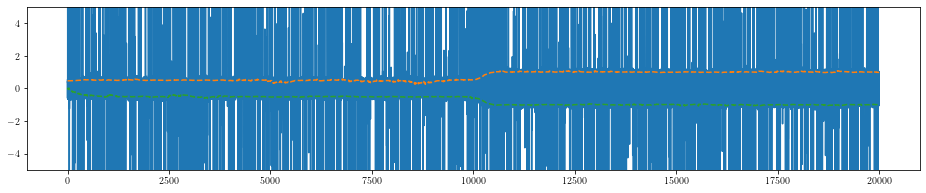

In [46]:
plt.figure(figsize=(16, 3))
plt.plot(X.ravel())
plt.plot(theta_est_sra[:, 3], linestyle='dashed')
plt.plot(theta_est_sra[:, 4], linestyle='dashed')
plt.ylim(-5, 5)
plt.show()

# choosing optimal rho

In [41]:
ratio_list = [0.05, 0.1, 0.5]
M_list = [1.0, 5.0, 10.0]
n_trial = 10
u = 20
alpha = 0.01

In [42]:
results_optrho = []
for trial in tqdm.tqdm(range(n_trial)):
    np.random.seed(trial)
    X = np.zeros((2*N, 1))
    Xj_former = generate_data(N, pi, mu1, sigma)
    X[:N, 0] = Xj_former.ravel()
    #Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
    Xj_trans = np.hstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma) for t in range(N, N+300) ])
    X[N:(N+300), 0] = Xj_trans
    Xj_latter = generate_data(N-300, pi, mu2, sigma)
    X[N+300:, 0] = Xj_latter.ravel()

    idxes_ol = np.random.choice(np.arange(2*N), int(alpha*2*N))
    X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)
    
    for gamma in [1, 3, 5, 10, 15]:
        print('gamma:', gamma)
        for ratio in ratio_list:
            print('\tratio:', ratio)
            for M in M_list:
                print('\t\tM:', M)
                rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
                print('\t\t\trho:', rho)
                rho_const = np.repeat(rho, X.shape[0])
                theta_est_sra = sra(X, theta0, rho_const, gamma)
                mse_pc = np.mean(np.sum((theta_est_sra[500:1000, 3:5] - mu1)**2, axis=1))
                mse_former = np.sum((theta_est_sra[1000:10000, 3:5] - mu1)**2, axis=1)
                mse_latter = np.sum((theta_est_sra[10000:, 3:5] - mu2)**2, axis=1)
                mse_overall = np.hstack((mse_former, mse_latter))
                print('\t\t\t\tmse:', np.mean(mse_former), np.mean(mse_latter), np.mean(mse_overall))
                results_optrho.append([gamma, ratio, M, rho, mse_pc, np.mean(mse_former), np.mean(mse_latter), np.mean(mse_overall)])

  0%|          | 0/10 [00:00<?, ?it/s]

gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


				mse: 0.02699489993986728 0.6947103747660147 0.378424097216787
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004314501362661296 0.007270237580727038 0.004030811949140292
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.00044478658363229724 0.007240636059757006 0.004021549465803196
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.017748054844314343 0.8768192827597033 0.4698908063787297
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0008927117010879378 0.8727000505772549 0.4597386795306494
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0009222721329307555 0.8752503088809013 0.46109492305291533
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.0018332880778473728 0.9344234789699203 0.49267023065262255
		M: 5.0
			rho: 0.2401973597880808


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:243: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


				mse: 0.2667147573927889 4.998076381400541 2.756905085817921
		M: 10.0
			rho: 0.24751245843729203
				mse: 0.28413899347361554 5.017614905927278 2.775442105291333
gamma: 3
	ratio: 0.05
		M: 1.0
			rho: 1.028415034055663e-06
				mse: 0.03839561521584404 0.7759620630013814 0.4265884824713901
		M: 5.0
			rho: 0.005813969383925258
				mse: 0.00015853514747816403 0.011009301382266847 0.005869464744735368
		M: 10.0
			rho: 0.007616093210593569
				mse: 0.0002099982587607504 0.009716627505238468 0.005213487335854285
	ratio: 0.1
		M: 1.0
			rho: 2.056830068111326e-06
				mse: 0.03839414945968362 0.7757922435351241 0.42649840949938916
		M: 5.0
			rho: 0.011627938767850517
				mse: 0.0003017617349161914 0.008511978129944694 0.004622928258615402
		M: 10.0
			rho: 0.015232186421187137
				mse: 0.00039437712998448266 0.008008845821351057 0.0044019922307037326
	ratio: 0.5
		M: 1.0
			rho: 1.028415034055663e-05
				mse: 0.038382423036582215 0.7743528768313263 0.4257352934548685
		M: 5.0
			rho: 0

 10%|█         | 1/10 [27:45<4:09:49, 1665.50s/it]

				mse: 0.01797478838335421 0.32152173178229787 0.17773633754069298
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.008690121282788794 0.5883214519077385 0.31375924266434124
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004984767175602795 0.5157264651819353 0.271671102225126
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0005132085921241696 0.7240183632957459 0.3813053952782408
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.0003854786525809019 0.007609987880161781 0.004187851930255047
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009921346125100932 0.8961348167263524 0.4721198620408482
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0010229684108436503 0.8984544231959725 0.47335531303459566
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.001952986470494757 0.9351921574577922 0.4931314975164408
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.2909861965531206 0.9903328519094808 0.6590633835827837
		M: 10.0
			rho: 0.247512458437

 20%|██        | 2/10 [51:54<3:25:03, 1537.92s/it]

				mse: 0.020628008004200546 0.2654705627959971 0.14949251052619872
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.04672734490461332 0.7475214012463921 0.41556632192660214
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004631802915713904 0.44098640174928494 0.23231750737457849
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0004779450258692291 0.44548657768666844 0.23469301484734253
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.0003506402960758277 0.0076331795634105104 0.004183555699936187
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009582602664626299 0.8468550100166742 0.44616707592446875
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0009889047336412299 0.8489827370678024 0.4473014480674103
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.0018917719440985467 0.9444719047693556 0.4979865786942338
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.2711904357023599 4.751887461224224 2.6294520280822886
		M: 10.0
			rho: 0.2475124

 30%|███       | 3/10 [1:15:39<2:53:26, 1486.68s/it]

				mse: 0.02237402827431181 0.29286800302137117 0.16473927814118514
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.0372445789137212 1.180581733486918 0.639000976057509
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0005963059466826082 0.2491058417301091 0.1313907984642755
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0006129374266459846 0.25363492951981725 0.1337824069493677
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.0004668354053667447 0.007438090726642068 0.0041359171534063885
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0011305759476525552 0.8830058775279096 0.46527547151620885
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0011627431883933857 0.8856076500300413 0.46666006257873455
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.002123735742954667 0.9412466981043435 0.496398979091054
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.28100914467598015 4.987405744230977 2.758059986547031
		M: 10.0
			rho: 0.247512458437292

 40%|████      | 4/10 [1:36:10<2:18:32, 1385.42s/it]

				mse: 0.023888763228561018 0.3408007622639314 0.19068455219454541
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.042049091087838046 0.7769569114317588 0.4288426807425331
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.00043214497842460883 0.4874960014543113 0.2567815431236281
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0004465886591975275 0.4921886876305263 0.25925821969673907
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.00032161850346325917 0.007668681113050558 0.0041884935611407855
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009145067922800647 0.8466025840828999 0.4460134948399747
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0009445820965676656 0.9078363091315527 0.47825601737813866
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.0018645085989357892 0.9443042787041602 0.49788544023326453
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.2574038960670585 4.933458277960026 2.718485149694936
		M: 10.0
			rho: 0.24751245

 50%|█████     | 5/10 [1:56:11<1:49:55, 1319.19s/it]

				mse: 0.02070563788651186 0.26460788880015923 0.1490752436305368
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.08022389466167809 0.8977386919760182 0.5104948406165939
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0005623481644301572 0.007307798143380466 0.004112584995456635
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0005787903914430723 0.007275690626746698 0.004103474725813401
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.0004350626177347457 0.007649271502131876 0.004232014662154288
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0010954763642990618 0.8958055452989425 0.4719955126456903
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.001127705555864192 0.8980436816473742 0.47318874560402735
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.002065358321438781 0.9383498560236114 0.49484667290152967
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.1546588561941435 4.979976238730766 2.6942995838449977
		M: 10.0
			rho: 0.2475124

 60%|██████    | 6/10 [2:16:06<1:25:06, 1276.72s/it]

				mse: 0.029082374298517018 0.3583805717351278 0.20239721505462793
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.055569804370385605 0.7912554756025175 0.4427727892294024
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004897303253097277 0.2635756516560982 0.13895600470993524
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0005046737697818658 0.2864548999167633 0.15100479279450896
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.00037589170000450304 0.007545468913631158 0.004149353391386953
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009943676415721469 0.8876913136306821 0.4676769707937352
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.001025876805232451 0.8900268151049091 0.46892110748927274
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.00197157819201609 0.9404483270444453 0.49590670916697893
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.26701834160705806 0.9792771482325221 0.6418913977257233
		M: 10.0
			rho: 0.247512458

 70%|███████   | 7/10 [2:36:47<1:03:15, 1265.23s/it]

				mse: 0.020051406400980784 0.3795115523088479 0.20924095687880562
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.020780007248210657 2.552099869205457 1.3530536188046562
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004930931947430617 0.10232118364130158 0.05408682500872124
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0005076837158559044 0.10248556735978823 0.05418025405476766
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.00038140356511391133 0.11620127480278646 0.06133923053230999
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009859313384031352 0.8988479782438877 0.47354490339392136
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.001016836955019173 0.9015871106385289 0.4750011915252875
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.001949624015259567 0.9394462583596099 0.49536890524912824
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.2619000108714738 4.109651223294757 2.28703222793636
		M: 10.0
			rho: 0.2475124584372

 80%|████████  | 8/10 [2:57:50<42:09, 1264.64s/it]  

				mse: 0.012270226746939247 0.3033367535276282 0.16546313557888082
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.01443860500090073 0.6521740367516162 0.35008883223811943
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.0004990261757834431 0.007784697211792591 0.004333589878946153
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0005139262694096528 0.007762998643578904 0.004329227518972417
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.000385386806260296 0.008076807998126373 0.004433503223031916
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0010073772578003772 0.9188814254411244 0.484098981564813
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.0010396105879683793 0.9188174119406664 0.4840805586683357
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.002005028077588449 0.9425315722261037 0.4970189986820701
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.29384852546792356 0.9873151465494091 0.6588309576160739
		M: 10.0
			rho: 0.247512

 90%|█████████ | 9/10 [3:22:49<22:17, 1337.72s/it]

				mse: 0.013336716724531822 0.3755117137401663 0.20395513620644465
gamma: 1
	ratio: 0.05
		M: 1.0
			rho: 0.009196986029286059
				mse: 0.05506161991912814 0.7361980302643835 0.41355446746926255
		M: 5.0
			rho: 0.02401973597880808
				mse: 0.00046539665224132787 0.39049197392956353 0.20574254258767408
		M: 10.0
			rho: 0.024751245843729203
				mse: 0.0004806670588928512 0.3699977624251831 0.1949633488306246
	ratio: 0.1
		M: 1.0
			rho: 0.018393972058572117
				mse: 0.00034995423860183 0.007925357124648837 0.004337008389152887
		M: 5.0
			rho: 0.04803947195761616
				mse: 0.0009866973740783648 0.7913526183968064 0.416968761070251
		M: 10.0
			rho: 0.049502491687458405
				mse: 0.001019345849174982 1.0375501961457436 0.5465618986368427
	ratio: 0.5
		M: 1.0
			rho: 0.09196986029286058
				mse: 0.001999534010459849 0.9416838663955844 0.49657023526578853
		M: 5.0
			rho: 0.2401973597880808
				mse: 0.2846568361442096 4.271223952361809 2.3828500552061045
		M: 10.0
			rho: 0.24751245843729

100%|██████████| 10/10 [3:47:58<00:00, 1367.87s/it]

				mse: 0.01725227502272468 0.2502965848545214 0.1399071749341966


In [43]:
results_optrho_df = pd.DataFrame(results_optrho, columns=['gamma', 'ratio', 'M', 'rho', 'pc', 'former', 'latter', 'overall'])

In [44]:
results_optrho_df

,gamma,ratio,M,rho,pc,former,latter,overall
0,1,0.05,1.0,9.196986e-03,0.027501,0.026995,0.694710,0.378424
1,1,0.05,5.0,2.401974e-02,0.000393,0.000431,0.007270,0.004031
2,1,0.05,10.0,2.475125e-02,0.000404,0.000445,0.007241,0.004022
3,1,0.10,1.0,1.839397e-02,0.017852,0.017748,0.876819,0.469891
4,1,0.10,5.0,4.803947e-02,0.000830,0.000893,0.872700,0.459739
5,1,0.10,10.0,4.950249e-02,0.000860,0.000922,0.875250,0.461095
6,1,0.50,1.0,9.196986e-02,0.001801,0.001833,0.934423,0.492670
7,1,0.50,5.0,2.401974e-01,0.005291,0.266715,4.998076,2.756905
8,1,0.50,10.0,2.475125e-01,0.311402,0.284139,5.017615,2.775442
9,3,0.05,1.0,1.028415e-06,0.038396,0.038396,0.775962,0.426588


In [45]:
results_optrho_df.groupby(['gamma', 'ratio', 'M', 'rho'])['pc'].agg([np.mean, np.std])

mean       std
gamma ratio M    rho                              
1     0.05  1.0  9.196986e-03   0.039322  0.021239
            5.0  2.401974e-02   0.000575  0.000201
            10.0 2.475125e-02   0.000591  0.000205
      0.10  1.0  1.839397e-02   0.002207  0.005500
            5.0  4.803947e-02   0.001113  0.000293
            10.0 4.950249e-02   0.001146  0.000297
      0.50  1.0  9.196986e-02   0.002150  0.000421
            5.0  2.401974e-01   0.096190  0.146454
            10.0 2.475125e-01   0.127421  0.157147
3     0.05  1.0  1.028415e-06   0.042479  0.019407
            5.0  5.813969e-03   0.004002  0.002924
            10.0 7.616093e-03   0.001232  0.000872
      0.10  1.0  2.056830e-06   0.042476  0.019405
            5.0  1.162794e-02   0.000379  0.000120
            10.0 1.523219e-02   0.000418  0.000135
      0.50  1.0  1.028415e-05   0.042450  0.019391
            5.0  5.813969e-02   0.001595  0.000477
            10.0 7.616093e-02   0.002107  0.000654
5     0.05  1.0  6.943972e-14   0.042483  0.019409
            5.0  1.839397e-03   0.029609  0.016170
            10.0 3.894004e-03   0.013339  0.007799
      0.10  1.0  1.388794e-13   0.042483  0.019409
            5.0  3.678794e-03   0.014820  0.008644
            10.0 7.788008e-03   0.002436  0.002523
      0.50  1.0  6.943972e-13   0.042483  0.019409
            5.0  1.839397e-02   0.000839  0.000535
            10.0 3.894004e-02   0.001763  0.001128
10    0.05  1.0  9.300190e-47   0.042483  0.019409
            5.0  4.578910e-05   0.042217  0.019360
            10.0 9.196986e-04   0.036463  0.018289
      0.10  1.0  1.860038e-46   0.042483  0.019409
            5.0  9.157819e-05   0.041948  0.019310
            10.0 1.839397e-03   0.029604  0.016278
      0.50  1.0  9.300190e-46   0.042483  0.019409
            5.0  4.578910e-04   0.039652  0.018883
            10.0 9.196986e-03   0.006078  0.004755
15    0.05  1.0  3.203246e-101  0.042483  0.019409
            5.0  2.056830e-07   0.042481  0.019409
            10.0 1.756654e-04   0.041429  0.019176
      0.10  1.0  6.406492e-101  0.042483  0.019409
            5.0  4.113660e-07   0.042480  0.019408
            10.0 3.513307e-04   0.040285  0.018937
      0.50  1.0  3.203246e-100  0.042483  0.019409
            5.0  2.056830e-06   0.042471  0.019406
            10.0 1.756654e-03   0.030324  0.016124

In [46]:
with open(os.path.join(outdir, 'results_optrho_df.pkl'), 'wb') as f:
    pickle.dump(results_optrho_df, f)

In [47]:
results_best = results_optrho_df.loc[
    ((results_optrho_df['gamma'] == 1) & (results_optrho_df['ratio'] == 0.05) & (results_optrho_df['M'] == 5.0) ) | 
    ((results_optrho_df['gamma'] == 3) & (results_optrho_df['ratio'] == 0.1) & (results_optrho_df['M'] == 5.0) ) |
    ((results_optrho_df['gamma'] == 5) & (results_optrho_df['ratio'] == 0.5) & (results_optrho_df['M'] == 5.0) ) | 
    ((results_optrho_df['gamma'] == 10) & (results_optrho_df['ratio'] == 0.5) & (results_optrho_df['M'] == 10.0) ) |
    ((results_optrho_df['gamma'] == 15) & (results_optrho_df['ratio'] == 0.5) & (results_optrho_df['M'] == 10.0) ) 
]

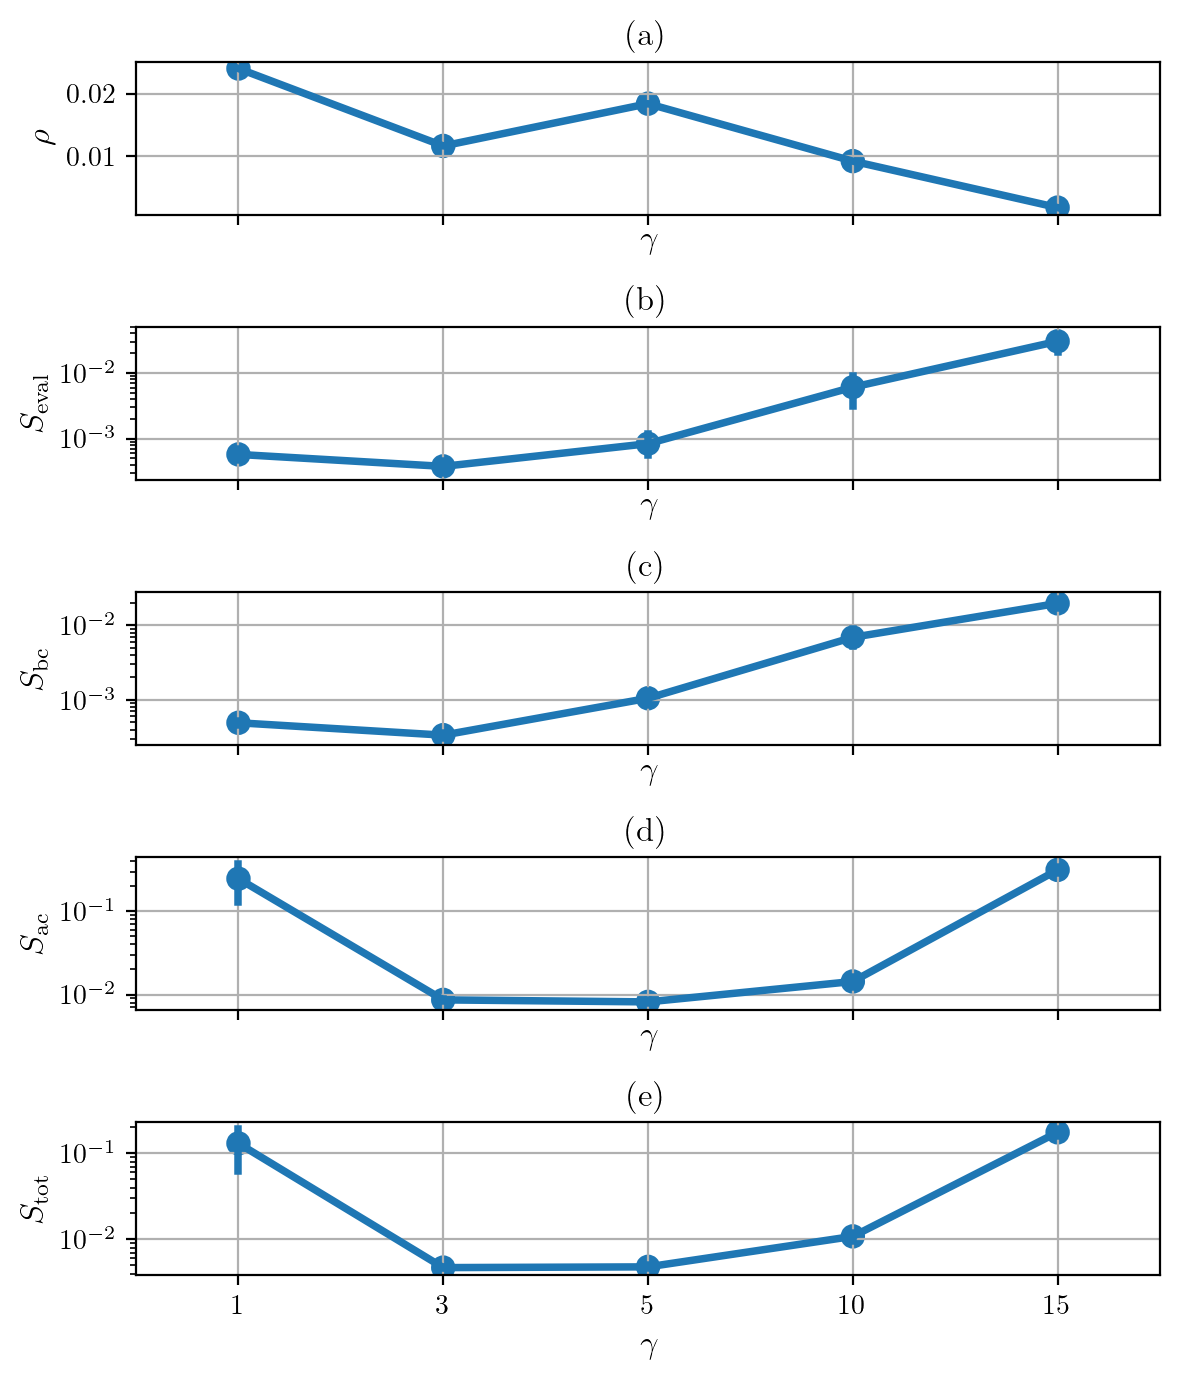

In [48]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(6, 7), dpi=200)

sns.pointplot(data=results_best, x='gamma', y='rho', ax=axes[0])
sns.pointplot(data=results_best, x='gamma', y='pc', ax=axes[1])
sns.pointplot(data=results_best, x='gamma', y='former', ax=axes[2])
sns.pointplot(data=results_best, x='gamma', y='latter', ax=axes[3])
sns.pointplot(data=results_best, x='gamma', y='overall', ax=axes[4])

axes[0].set_title('(a)', fontsize=12)
axes[0].set_xlabel(r'$\gamma$', fontsize=12)
axes[0].set_ylabel(r'$\rho$', fontsize=12)
axes[0].grid()

axes[1].set_title('(b)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$\gamma$', fontsize=12)
axes[1].set_ylabel(r'$S_{\mathrm{eval}}$', fontsize=12)
axes[1].grid()

axes[2].set_title('(c)', fontsize=12)
axes[2].set_yscale('log')
axes[2].set_xlabel(r'$\gamma$', fontsize=12)
axes[2].set_ylabel(r'$S_{\mathrm{bc}}$', fontsize=12)
axes[2].grid()

axes[3].set_title('(d)', fontsize=12)
axes[3].set_yscale('log')
axes[3].set_xlabel(r'$\gamma$', fontsize=12)
axes[3].set_ylabel(r'$S_{\mathrm{ac}}$', fontsize=12)
axes[3].grid()

axes[4].set_title('(e)', fontsize=12)
axes[4].set_yscale('log')
axes[4].set_xlabel(r'$\gamma$', fontsize=12)
axes[4].set_ylabel(r'$S_{\mathrm{tot}}$', fontsize=12)


plt.rc('font', family='serif')
axes[4].set_xticklabels([1, 3, 5, 10, 15])

axes[4].grid()


plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'gamma_rho_tradeoff.pdf'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'gamma_rho_tradeoff.eps'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'gamma_rho_tradeoff.png'), dpi=200, bbox_inches='tight')